In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [3]:
from huggingface_hub import login
from transformers import AutoTokenizer
from datasets import load_dataset
from google.colab import drive
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from transformers import EarlyStoppingCallback

In [4]:
drive.mount('/content/drive')

%cd /content/drive/MyDrive/grad_school/deep_learning/project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/grad_school/deep_learning/project


In [5]:

login()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-29-9595cc8f4ad0>:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Epoch,Training Loss,Validation Loss
17,0.659200,0.826872
18,0.648400,0.827754
19,0.637700,0.829303
20,0.628800,0.829040


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


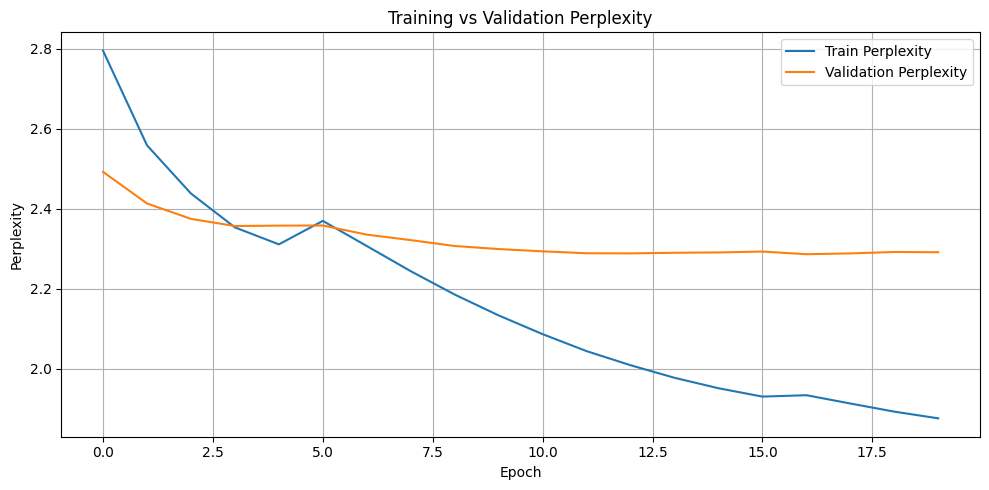

In [29]:
# Load dataset
data_files = {
    "train": "train_data.jsonl",
    "validation": "validation_data.jsonl",
    "test": "test_data.jsonl"
}
dataset = load_dataset("json", data_files=data_files)

model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def preprocess(example):
    model_input = tokenizer(
        example["input"], padding="max_length", truncation=True, max_length=50
    )
    label = tokenizer(
        example["response"], padding="max_length", truncation=True, max_length=50
    )
    label_ids = [id if id != tokenizer.pad_token_id else -100 for id in label["input_ids"]]
    model_input["labels"] = label_ids
    return model_input

tokenized_datasets = dataset.map(preprocess, batched=True)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-emotion-dialogue",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir=None,
    learning_rate=1e-4, # 5e-4 5e-3
    lr_scheduler_type="cosine",
    per_device_train_batch_size=16, # 8
    per_device_eval_batch_size=16, # 8
    num_train_epochs=25,
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=None,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

train_result = trainer.train(resume_from_checkpoint=True)
trainer.save_model("./t5-emotion-dialogue-final")
tokenizer.save_pretrained("./t5-emotion-dialogue-final")

logs = trainer.state.log_history
train_losses = [log["loss"] for log in logs if "loss" in log]
eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]

train_perplexities = [math.exp(l) if l < 100 else float('inf') for l in train_losses]
eval_perplexities = [math.exp(l) if l < 100 else float('inf') for l in eval_losses]

plt.figure(figsize=(10, 5))
plt.plot(train_perplexities, label="Train Perplexity")
plt.plot(eval_perplexities, label="Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Training vs Validation Perplexity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("perplexity_plot.png")
plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "./t5-emotion-dialogue-final"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)

def generate_response(input_text):
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=50).to(device)
    outputs = model.generate(**inputs, max_length=50)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example usage
print(generate_response("emotion: fear | How are you feeling today?"))


print(generate_response("emotion: sad | context: How is your day going?"))

I'm feeling terrible.
I'm fine. I'm going to have to go to the gym.
